In [1]:
import os
import os.path
import glob
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                                                                                                                       
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn import svm
from sklearn.model_selection import GridSearchCV
import sklearn_evaluation.plot as skplot
from sklearn.model_selection import learning_curve

import matplotlib.pyplot as plt

import numpy as np
np.random.seed(1)

from keras.preprocessing.image import img_to_array
from keras.utils import np_utils
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.imagenet_utils import preprocess_input

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

Using TensorFlow backend.


In [2]:
imagedir = "Datasets/Detection/Byteplots"

In [3]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.png'))  # assuming the images are stored as 'png'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.png'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Family:          Banker	Number of images: 1986
Label: 1	Family:          WinExe	Number of images: 1945
Processing images ...


/usr/local/lib/python2.7/dist-packages/PIL/Image.py:2371: DecompressionBombWarning: Image size (103265280 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)
/usr/local/lib/python2.7/dist-packages/PIL/Image.py:2371: DecompressionBombWarning: Image size (110601216 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Images processed: 3931


In [4]:
X.shape

(3931, 224, 224, 3)

In [5]:
# Creating base_model
image_shape = (224, 224, 3)                                                                                                                                                                                                                                                                                            
base_model = VGG16(weights='imagenet', input_shape=image_shape, include_top=False, pooling='avg')

In [6]:
print("Extracting bottleneck features from convolutional layers ...")
bnfeatures = base_model.predict(X)

Extracting bottleneck features from convolutional layers ...


In [7]:
bnfeatures.shape

(3931, 512)

In [8]:
# Create stratified k-fold subsets                                                                                                                                        
kfold = 5  # no. of folds                                                                 
skf = StratifiedKFold(kfold, shuffle=True,random_state=1)

In [9]:
# Training top_model
C_range = np.logspace(-2, 3, 6)
gamma_range = np.logspace(-8, 1, 10)
param_grid = dict(gamma=gamma_range, C=C_range)

top_model = GridSearchCV(svm.SVC(), param_grid=param_grid, cv=skf, verbose=10, n_jobs=-1)
top_model.fit(bnfeatures,y)  # Training 

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-07 .............................................
[CV] C=0.01, gamma=1e-07 .............................................
[CV] C=0.01, gamma=1e-07 .............................................
[CV] C=0.01, gamma=1e-07 .............................................
[CV] C=0.01, gamma=1e-07 .............................................
[CV] C=0.01, gamma=1e-06 .............................................
[CV] C=0.01, gamma=1e-06 .............................................
[CV] C=0.01, gamma=1e-06 .............................................
[CV] C=0.01, ga

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   35.8s


[CV] ............. C=0.01, gamma=0.0001, score=0.888041, total=  20.1s
[CV] C=0.01, gamma=0.001 .............................................
[CV] .............. C=0.01, gamma=1e-08, score=0.505089, total=  29.9s
[CV] C=0.01, gamma=0.001 .............................................
[CV] .............. C=0.01, gamma=1e-06, score=0.505089, total=  29.6s
[CV] .............. C=0.01, gamma=1e-06, score=0.505089, total=  29.9s
[CV] C=0.01, gamma=0.01 ..............................................
[CV] C=0.01, gamma=0.001 .............................................
[CV] .............. C=0.01, gamma=1e-08, score=0.505089, total=  30.1s
[CV] C=0.01, gamma=0.01 ..............................................
[CV] .............. C=0.01, gamma=1e-07, score=0.505718, total=  30.3s
[CV] .............. C=0.01, gamma=1e-05, score=0.727735, total=  30.0s
[CV] C=0.01, gamma=0.01 ..............................................
[CV] .............. C=0.01, gamma=1e-06, score=0.505089, total=  29.9s
[CV] C

[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:   53.7s


[CV] .............. C=0.01, gamma=1e-07, score=0.505089, total=  30.7s
[CV] C=0.01, gamma=0.1 ...............................................
[CV] .............. C=0.01, gamma=1e-07, score=0.505089, total=  30.4s
[CV] C=0.01, gamma=0.1 ...............................................
[CV] .............. C=0.01, gamma=1e-08, score=0.505089, total=  30.6s
[CV] C=0.01, gamma=0.1 ...............................................
[CV] .............. C=0.01, gamma=1e-08, score=0.505089, total=  30.3s
[CV] C=0.01, gamma=1.0 ...............................................
[CV] .............. C=0.01, gamma=1e-07, score=0.505089, total=  30.8s
[CV] C=0.01, gamma=1.0 ...............................................
[CV] .............. C=0.01, gamma=1e-06, score=0.505089, total=  31.1s
[CV] .............. C=0.01, gamma=1e-05, score=0.744275, total=  31.2s
[CV] .............. C=0.01, gamma=1e-05, score=0.737913, total=  30.9s
[CV] .............. C=0.01, gamma=1e-08, score=0.505718, total=  31.3s
[CV] C

[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   55.9s


[CV] ............. C=0.01, gamma=0.0001, score=0.903308, total=  19.4s
[CV] C=0.01, gamma=10.0 ..............................................
[CV] .............. C=0.01, gamma=0.001, score=0.744600, total=  30.6s
[CV] C=0.01, gamma=10.0 ..............................................
[CV] .............. C=0.01, gamma=0.001, score=0.754453, total=  31.1s
[CV] C=0.1, gamma=1e-08 ..............................................
[CV] .............. C=0.01, gamma=0.001, score=0.781170, total=  31.1s
[CV] C=0.1, gamma=1e-08 ..............................................
[CV] .............. C=0.01, gamma=0.001, score=0.758270, total=  30.1s
[CV] C=0.1, gamma=1e-08 ..............................................
[CV] ............... C=0.01, gamma=0.01, score=0.505718, total=  29.3s
[CV] C=0.1, gamma=1e-08 ..............................................
[CV] ............... C=0.01, gamma=0.01, score=0.505089, total=  29.5s
[CV] C=0.1, gamma=1e-08 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.8min


[CV] ................ C=0.01, gamma=0.1, score=0.505089, total=  29.8s
[CV] C=0.1, gamma=1e-06 ..............................................
[CV] ................ C=0.01, gamma=1.0, score=0.505718, total=  29.7s
[CV] C=0.1, gamma=1e-06 ..............................................
[CV] ................ C=0.01, gamma=1.0, score=0.505089, total=  29.4s
[CV] C=0.1, gamma=1e-06 ..............................................
[CV] ............... C=0.01, gamma=10.0, score=0.505718, total=  29.6s
[CV] C=0.1, gamma=1e-06 ..............................................
[CV] ................ C=0.01, gamma=0.1, score=0.505089, total=  30.3s
[CV] C=0.1, gamma=1e-05 ..............................................
[CV] ................ C=0.01, gamma=0.1, score=0.505089, total=  30.1s
[CV] C=0.1, gamma=1e-05 ..............................................
[CV] ................ C=0.01, gamma=1.0, score=0.505089, total=  30.1s
[CV] C=0.1, gamma=1e-05 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:  2.1min


[CV] .............. C=0.1, gamma=0.0001, score=0.924936, total=  10.3s
[CV] C=0.1, gamma=0.0001 .............................................
[CV] ............... C=0.1, gamma=1e-05, score=0.897078, total=  16.1s
[CV] C=0.1, gamma=0.001 ..............................................
[CV] ............... C=0.1, gamma=1e-05, score=0.900763, total=  16.1s
[CV] C=0.1, gamma=0.001 ..............................................
[CV] ............... C=0.1, gamma=1e-05, score=0.900763, total=  16.2s
[CV] C=0.1, gamma=0.001 ..............................................
[CV] ............... C=0.1, gamma=1e-05, score=0.926209, total=  16.6s
[CV] C=0.1, gamma=0.001 ..............................................
[CV] ............... C=0.1, gamma=1e-05, score=0.913486, total=  17.2s
[CV] C=0.1, gamma=0.001 ..............................................
[CV] .............. C=0.1, gamma=0.0001, score=0.947837, total=  10.0s
[CV] C=0.1, gamma=0.01 ...............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:  2.6min


[CV] ............... C=0.1, gamma=1e-07, score=0.505089, total=  30.4s
[CV] C=0.1, gamma=1.0 ................................................
[CV] ............... C=0.1, gamma=1e-07, score=0.505089, total=  30.5s
[CV] C=0.1, gamma=1.0 ................................................
[CV] ............... C=0.1, gamma=1e-07, score=0.505089, total=  30.5s
[CV] C=0.1, gamma=1.0 ................................................
[CV] ............... C=0.1, gamma=1e-07, score=0.505718, total=  31.4s
[CV] C=0.1, gamma=1.0 ................................................
[CV] ............... C=0.1, gamma=1e-06, score=0.776081, total=  30.4s
[CV] C=0.1, gamma=1.0 ................................................
[CV] ............... C=0.1, gamma=1e-06, score=0.795426, total=  31.5s
[CV] C=0.1, gamma=10.0 ...............................................
[CV] ............... C=0.1, gamma=1e-06, score=0.798982, total=  30.0s
[CV] C=0.1, gamma=10.0 ...............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:  2.9min


[CV] ................ C=0.1, gamma=0.01, score=0.570521, total=  29.3s
[CV] C=1.0, gamma=1e-08 ..............................................
[CV] ................ C=0.1, gamma=0.01, score=0.573791, total=  29.8s
[CV] C=1.0, gamma=1e-07 ..............................................
[CV] ................ C=0.1, gamma=0.01, score=0.566158, total=  29.2s
[CV] C=1.0, gamma=1e-07 ..............................................
[CV] ................ C=0.1, gamma=0.01, score=0.609415, total=  29.6s
[CV] ................ C=0.1, gamma=0.01, score=0.555980, total=  29.1s
[CV] C=1.0, gamma=1e-07 ..............................................
[CV] C=1.0, gamma=1e-07 ..............................................
[CV] ................. C=0.1, gamma=0.1, score=0.515883, total=  29.6s
[CV] C=1.0, gamma=1e-07 ..............................................
[CV] ................. C=0.1, gamma=1.0, score=0.505718, total=  29.8s
[CV] C=1.0, gamma=1e-06 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  3.6min


[CV] ................ C=0.1, gamma=10.0, score=0.505089, total=  30.2s
[CV] C=1.0, gamma=0.0001 .............................................
[CV] ................ C=0.1, gamma=10.0, score=0.505089, total=  30.1s
[CV] C=1.0, gamma=0.0001 .............................................
[CV] ................ C=0.1, gamma=10.0, score=0.505089, total=  30.0s
[CV] C=1.0, gamma=0.0001 .............................................
[CV] ............... C=1.0, gamma=1e-08, score=0.505089, total=  31.8s
[CV] C=1.0, gamma=0.0001 .............................................
[CV] ............... C=1.0, gamma=1e-08, score=0.505089, total=  31.7s
[CV] C=1.0, gamma=0.001 ..............................................
[CV] ............... C=1.0, gamma=1e-08, score=0.505718, total=  32.3s
[CV] C=1.0, gamma=0.001 ..............................................
[CV] ............... C=1.0, gamma=1e-08, score=0.505089, total=  31.9s
[CV] C=1.0, gamma=0.001 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:  4.0min


[CV] ............... C=1.0, gamma=1e-06, score=0.898348, total=  16.1s
[CV] C=1.0, gamma=0.1 ................................................
[CV] ............... C=1.0, gamma=1e-06, score=0.899491, total=  16.2s
[CV] C=1.0, gamma=0.1 ................................................
[CV] ............... C=1.0, gamma=1e-06, score=0.903308, total=  16.3s
[CV] C=1.0, gamma=1.0 ................................................
[CV] ............... C=1.0, gamma=1e-06, score=0.923664, total=  16.6s
[CV] C=1.0, gamma=1.0 ................................................
[CV] ............... C=1.0, gamma=1e-06, score=0.913486, total=  16.7s
[CV] C=1.0, gamma=1.0 ................................................
[CV] ............... C=1.0, gamma=1e-08, score=0.505089, total=  31.1s
[CV] C=1.0, gamma=1.0 ................................................
[CV] ............... C=1.0, gamma=1e-07, score=0.797967, total=  31.3s
[CV] C=1.0, gamma=1.0 ................................................
[CV] .

[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed:  4.7min


[CV] ................ C=1.0, gamma=0.01, score=0.730280, total=  29.4s
[CV] C=10.0, gamma=1e-07 .............................................
[CV] ................ C=1.0, gamma=0.01, score=0.753181, total=  30.8s
[CV] C=10.0, gamma=1e-07 .............................................
[CV] ................. C=1.0, gamma=0.1, score=0.588310, total=  29.8s
[CV] C=10.0, gamma=1e-07 .............................................
[CV] ................. C=1.0, gamma=0.1, score=0.611959, total=  30.0s
[CV] C=10.0, gamma=1e-06 .............................................
[CV] ................. C=1.0, gamma=0.1, score=0.611959, total=  30.1s
[CV] C=10.0, gamma=1e-06 .............................................
[CV] ................. C=1.0, gamma=0.1, score=0.600509, total=  29.8s
[CV] C=10.0, gamma=1e-06 .............................................
[CV] ................. C=1.0, gamma=1.0, score=0.536213, total=  29.2s
[CV] C=10.0, gamma=1e-06 .............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:  5.1min


[CV] C=10.0, gamma=0.001 .............................................
[CV] .............. C=10.0, gamma=1e-08, score=0.783715, total=  30.9s
[CV] C=10.0, gamma=0.001 .............................................
[CV] .............. C=10.0, gamma=1e-06, score=0.923664, total=   9.8s
[CV] C=10.0, gamma=0.001 .............................................
[CV] .............. C=10.0, gamma=1e-07, score=0.898348, total=  16.3s
[CV] C=10.0, gamma=0.001 .............................................
[CV] .............. C=10.0, gamma=1e-08, score=0.797967, total=  32.2s
[CV] C=10.0, gamma=0.01 ..............................................
[CV] .............. C=10.0, gamma=1e-06, score=0.930025, total=   9.3s
[CV] C=10.0, gamma=0.01 ..............................................
[CV] .............. C=10.0, gamma=1e-06, score=0.945293, total=   9.7s
[CV] C=10.0, gamma=0.01 ..............................................
[CV] .............. C=10.0, gamma=1e-08, score=0.809160, total=  32.2s
[CV] .

[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  5.3min


[CV] ............. C=10.0, gamma=0.0001, score=0.970738, total=   5.8s
[CV] C=10.0, gamma=10.0 ..............................................
[CV] .............. C=10.0, gamma=1e-08, score=0.806616, total=  30.5s
[CV] C=10.0, gamma=10.0 ..............................................
[CV] .............. C=10.0, gamma=0.001, score=0.952986, total=  15.0s
[CV] C=10.0, gamma=10.0 ..............................................
[CV] .............. C=10.0, gamma=0.001, score=0.952926, total=  15.4s
[CV] C=100.0, gamma=1e-08 ............................................
[CV] .............. C=10.0, gamma=0.001, score=0.946565, total=  15.3s
[CV] C=100.0, gamma=1e-08 ............................................
[CV] .............. C=10.0, gamma=0.001, score=0.949109, total=  15.3s
[CV] C=100.0, gamma=1e-08 ............................................
[CV] .............. C=10.0, gamma=0.001, score=0.966921, total=  15.7s
[CV] C=100.0, gamma=1e-08 ............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed:  6.1min


[CV] ................ C=10.0, gamma=1.0, score=0.554707, total=  29.0s
[CV] C=100.0, gamma=1e-05 ............................................
[CV] ............. C=100.0, gamma=1e-08, score=0.903308, total=  16.9s
[CV] C=100.0, gamma=0.0001 ...........................................
[CV] ................ C=10.0, gamma=1.0, score=0.548346, total=  30.0s
[CV] C=100.0, gamma=0.0001 ...........................................
[CV] ................ C=10.0, gamma=1.0, score=0.562341, total=  29.5s
[CV] C=100.0, gamma=0.0001 ...........................................
[CV] ............... C=10.0, gamma=10.0, score=0.524778, total=  29.1s
[CV] C=100.0, gamma=0.0001 ...........................................
[CV] ............... C=10.0, gamma=10.0, score=0.527990, total=  29.7s
[CV] C=100.0, gamma=0.0001 ...........................................
[CV] ............... C=10.0, gamma=10.0, score=0.516539, total=  29.5s
[CV] C=100.0, gamma=0.001 ............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 217 tasks      | elapsed:  6.3min


[CV] ............ C=100.0, gamma=0.0001, score=0.972010, total=   5.8s
[CV] C=100.0, gamma=1.0 ..............................................
[CV] ............. C=100.0, gamma=1e-07, score=0.928753, total=   9.8s
[CV] C=100.0, gamma=1.0 ..............................................
[CV] ............ C=100.0, gamma=0.0001, score=0.968193, total=   5.9s
[CV] C=100.0, gamma=1.0 ..............................................
[CV] ............. C=100.0, gamma=1e-07, score=0.928753, total=   9.5s
[CV] C=100.0, gamma=10.0 .............................................
[CV] ............... C=10.0, gamma=10.0, score=0.520356, total=  29.2s
[CV] C=100.0, gamma=10.0 .............................................
[CV] ............... C=10.0, gamma=10.0, score=0.522901, total=  30.7s
[CV] C=100.0, gamma=10.0 .............................................
[CV] ............. C=100.0, gamma=1e-08, score=0.913486, total=  16.4s
[CV] C=100.0, gamma=10.0 .............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:  7.2min


[CV] ............ C=1000.0, gamma=1e-07, score=0.944091, total=   6.9s
[CV] C=1000.0, gamma=1e-06 ...........................................
[CV] .............. C=100.0, gamma=0.01, score=0.745870, total=  31.1s
[CV] C=1000.0, gamma=1e-05 ...........................................
[CV] ............... C=100.0, gamma=0.1, score=0.589581, total=  29.3s
[CV] C=1000.0, gamma=1e-05 ...........................................
[CV] ............ C=1000.0, gamma=1e-07, score=0.944020, total=   6.7s
[CV] C=1000.0, gamma=1e-05 ...........................................
[CV] ............... C=100.0, gamma=0.1, score=0.610687, total=  29.7s
[CV] C=1000.0, gamma=1e-05 ...........................................
[CV] ............ C=1000.0, gamma=1e-07, score=0.954198, total=   7.2s
[CV] C=1000.0, gamma=1e-05 ...........................................
[CV] ............... C=100.0, gamma=0.1, score=0.604326, total=  30.5s
[CV] ............... C=100.0, gamma=1.0, score=0.540025, total=  29.6s
[CV] C

[Parallel(n_jobs=-1)]: Done 284 out of 300 | elapsed:  8.1min remaining:   27.3s


[CV] .............. C=1000.0, gamma=0.1, score=0.615776, total=  27.8s
[CV] .............. C=1000.0, gamma=0.1, score=0.610687, total=  27.8s
[CV] .............. C=1000.0, gamma=0.1, score=0.604326, total=  27.9s
[CV] ............. C=1000.0, gamma=0.01, score=0.745870, total=  30.2s
[CV] .............. C=1000.0, gamma=1.0, score=0.554707, total=  27.3s
[CV] ............. C=1000.0, gamma=10.0, score=0.516539, total=  26.9s
[CV] .............. C=1000.0, gamma=0.1, score=0.614504, total=  30.0s
[CV] .............. C=1000.0, gamma=0.1, score=0.589581, total=  29.2s
[CV] .............. C=1000.0, gamma=1.0, score=0.540025, total=  28.6s
[CV] .............. C=1000.0, gamma=1.0, score=0.562341, total=  28.9s
[CV] .............. C=1000.0, gamma=1.0, score=0.545802, total=  29.6s
[CV] ............. C=1000.0, gamma=10.0, score=0.524778, total=  29.0s
[CV] .............. C=1000.0, gamma=1.0, score=0.548346, total=  29.0s
[CV] ............. C=1000.0, gamma=10.0, score=0.527990, total=  29.4s
[CV] .

[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  8.3min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
       error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'C': array([  1.00000e-02,   1.00000e-01,   1.00000e+00,   1.00000e+01,
         1.00000e+02,   1.00000e+03]), 'gamma': array([  1.00000e-08,   1.00000e-07,   1.00000e-06,   1.00000e-05,
         1.00000e-04,   1.00000e-03,   1.00000e-02,   1.00000e-01,
         1.00000e+00,   1.00000e+01])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=10)

In [10]:
top_model.cv_results_

{'mean_fit_time': array([ 24.65344839,  24.99401159,  24.46062446,  24.809446  ,
         16.14921618,  24.90698905,  23.70276437,  24.00397372,
         23.61296582,  23.90895419,  25.56979699,  24.94027519,
         25.13609781,  13.2423892 ,   8.13727765,  13.76383805,
         23.56624975,  24.14218383,  24.02278404,  24.11172104,
         25.80872192,  25.55074887,  13.14705977,   7.69967003,
          5.43732791,  12.03385844,  24.27528224,  24.14483781,
         23.61029558,  23.89781761,  25.67667379,  13.42051167,
          7.79693303,   5.40841699,   4.72390165,  12.37212424,
         24.61704164,  24.07465477,  23.4368206 ,  23.61416116,
         13.25779057,   7.86732478,   5.6173038 ,   4.95028815,
          4.85298886,  12.19712057,  24.50895972,  23.88154068,
         23.76863174,  23.76761656,   7.79419856,   5.58397503,
          4.95441537,   5.22194657,   4.52916245,  11.98220162,
         24.11246519,  23.74378886,  23.5273541 ,  23.0400435 ]),
 'mean_score_time': a

In [11]:
top_model.grid_scores_

/usr/local/lib/python2.7/dist-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.50521, std: 0.00025, params: {'C': 0.01, 'gamma': 1e-08},
 mean: 0.50521, std: 0.00025, params: {'C': 0.01, 'gamma': 9.9999999999999995e-08},
 mean: 0.50521, std: 0.00025, params: {'C': 0.01, 'gamma': 9.9999999999999995e-07},
 mean: 0.73951, std: 0.00735, params: {'C': 0.01, 'gamma': 1.0000000000000001e-05},
 mean: 0.89723, std: 0.01033, params: {'C': 0.01, 'gamma': 0.0001},
 mean: 0.75680, std: 0.01324, params: {'C': 0.01, 'gamma': 0.001},
 mean: 0.50521, std: 0.00025, params: {'C': 0.01, 'gamma': 0.01},
 mean: 0.50521, std: 0.00025, params: {'C': 0.01, 'gamma': 0.10000000000000001},
 mean: 0.50521, std: 0.00025, params: {'C': 0.01, 'gamma': 1.0},
 mean: 0.50521, std: 0.00025, params: {'C': 0.01, 'gamma': 10.0},
 mean: 0.50521, std: 0.00025, params: {'C': 0.10000000000000001, 'gamma': 1e-08},
 mean: 0.50521, std: 0.00025, params: {'C': 0.10000000000000001, 'gamma': 9.9999999999999995e-08},
 mean: 0.79064, std: 0.01066, params: {'C': 0.10000000000000001, 'gamma': 9.99999999999

In [12]:
print("Best parameters: %s - score: %0.4f" % (top_model.best_params_, top_model.best_score_))

Best parameters: {'C': 10.0, 'gamma': 0.0001} - score: 0.9730


/usr/local/lib/python2.7/dist-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


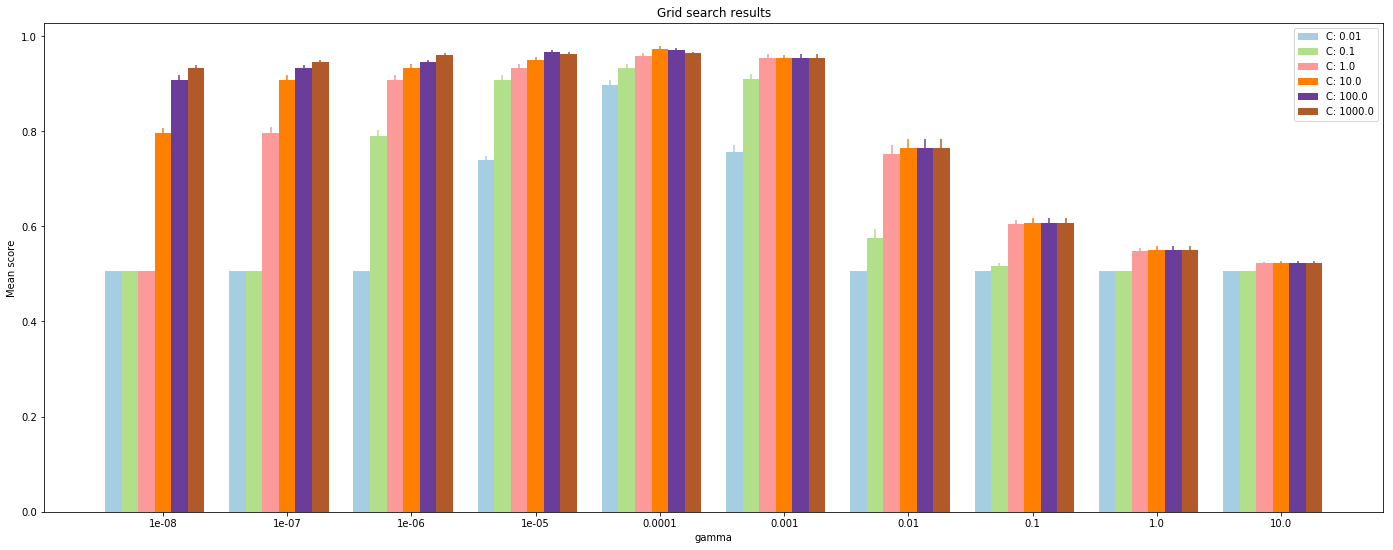

In [13]:
plt.rcParams['image.cmap'] = 'Paired'
skplot.grid_search(top_model.grid_scores_, change='gamma', kind='bar')
figure = plt.gcf()
figure.set_size_inches(24, 9)
plt.show()